In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from os import listdir
from os.path import isfile, join
from rabies_somadetector_data import brain2paths, brain2centers
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
Validation errors in config file(s).
The following fields have been reset to the default value:

application -> window_fullscreen
  none is not an allowed value (type=type_error.none.not_allowed)
plugins -> call_order
  none is not an allowed value (type=type_error.none.not_allowed)



embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


In [2]:
brain = "r1"
channel = "3channel"
dir = brain2paths[brain][0]
vol_fg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][1]
vol_bg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][2]
vol_endo = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
print(vol_fg.shape)

soma_centers = brain2centers[brain][0][0]
nonsoma_centers = brain2centers[brain][1][0]

print(f"{len(soma_centers)} soma centers")
print(f"{len(nonsoma_centers)} nonsoma centers")


(5602, 7360, 3300, 1)
100 soma centers
20 nonsoma centers


## Save images

In [ ]:
dset_name = "test"

type = "pos"
for i, center in enumerate(soma_centers):
    if i >=2:
        continue
    image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_fg = image_fg[:,:,:,0]
    image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_bg = image_bg[:,:,:,0]
    image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_endo = image_endo[:,:,:,0]

    image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image)

type = "neg"
for i, center in enumerate(nonsoma_centers):
    if i >=5:
        continue
    image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_fg = image_fg[:,:,:,0]
    image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_bg = image_bg[:,:,:,0]
    image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_endo = image_endo[:,:,:,0]


    image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image)
        

## Evaluate performance

['3005_3506_1550_neg_Probabilities.h5', '3086_4087_1875_neg_Probabilities.h5', '1102_1870_1854_neg_Probabilities.h5', '1847_3412_1539_pos_Probabilities.h5', '2897_3204_1300_neg_Probabilities.h5', '3049_5896_1018_pos_Probabilities.h5', '3214_5058_1903_pos_Probabilities.h5', '2652_5673_786_pos_Probabilities.h5', '30_6212_3270_neg_Probabilities.h5', '1820_4988_799_neg_Probabilities.h5', '785_2881_1418_pos_Probabilities.h5', '3545_5263_1387_neg_Probabilities.h5', '3918_5896_796_neg_Probabilities.h5', '3271_4756_1557_neg_Probabilities.h5', '401_6266_3270_neg_Probabilities.h5', '1411_4952_1653_pos_Probabilities.h5', '2568_4020_1544_pos_Probabilities.h5', '2303_2849_749_pos_Probabilities.h5', '92_6539_3270_neg_Probabilities.h5', '3654_4952_1387_neg_Probabilities.h5', '3852_5670_1325_pos_Probabilities.h5', '1743_2824_1373_neg_Probabilities.h5', '378_6549_3270_neg_Probabilities.h5', '2422_5315_1702_neg_Probabilities.h5', '2636_2863_956_pos_Probabilities.h5', '3077_4926_1903_pos_Probabilities.h5

<matplotlib.legend.Legend object at 0x15f43a0d0>

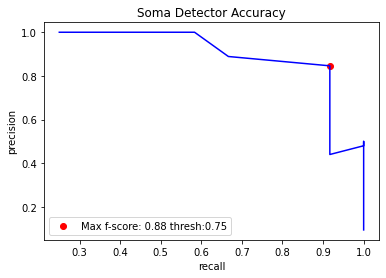

In [5]:
recalls = []
precisions = []

files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/test/"
onlyfiles = [f for f in listdir(files_dir) if isfile(join(files_dir, f))]
#test_files = [f for f in onlyfiles if f[:4] == "test"]
test_files = [f for f in onlyfiles if "Probabilities" in f] #"probabilities"
print(test_files)

for threshold in np.arange(0.05,1.0,0.05):
    tot_pos = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files, disable=True):
        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[0,:,:,:]
        mask = pred>threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        if "pos" in filename: 
            first = True
            tot_pos += 1
            for prop in props:
                if prop["area"] > 50:
                    if first:
                        true_pos += 1
                        first = False
                    else:
                        false_pos += 1
        elif "neg" in filename:
            for prop in props:
                if prop["area"] > 50:
                    false_pos += 1

    recall = true_pos/tot_pos
    recalls.append(recall)
    if true_pos + false_pos == 0:
        precision = 0
    else:
        precision = true_pos/(true_pos + false_pos)
    precisions.append(precision)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2*precision*recall/(precision+recall)
    print(f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {fscore} for {tot_pos} positive samples in {len(test_files)} images")

fscores = [2*precision*recall/(precision+recall) if (precision != 0 and recall != 0) else 0 for precision,recall in zip(precisions, recalls) ]
idx = np.argmax(fscores)
best_threshold = np.arange(0.05,1.0,0.05)[idx]
plt.plot(recalls, precisions, c='b')
plt.scatter(recalls[idx], precisions[idx], c='r', label=f"Max f-score: {fscores[idx]:.2f} thresh:{best_threshold:.2f}")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Soma Detector Accuracy")
plt.legend()


In [20]:
for filename in tqdm(test_files, disable=True):
    im_fname = fname[:-17] + ".h5"
    fname = files_dir + filename
    f = h5py.File(fname, "r")
    pred = f.get("exported_data")
    pred = pred[0,:,:,:]
    mask = pred>best_threshold
    labels = measure.label(mask)
    props = measure.regionprops(labels)

    if "pos" in filename: 
        first = True
        tot_pos += 1
        for prop in props:
            if prop["area"] > 50:
                if first:
                    true_pos += 1
                    first = False
                else:
                    print(f"Soma false positive Area: {area}")
                    f = h5py.File(im_fname, "r")
                    im = f.get("image_3channel")
                    im = im[0,:,:,:]
                    viewer = napari.Viewer(ndisplay=3)
                    viewer.add_image(im)
                    viewer.add_labels(mask)
                    viewer.add_labels(mask == prop["label"])
                    false_pos += 1
        if first == False:
            print(f"Soma false negative")
            f = h5py.File(im_fname, "r")
            im = f.get("image_3channel")
            im = im[0,:,:,:]
            viewer = napari.Viewer(ndisplay=3)
            viewer.add_image(im)
            viewer.add_labels(mask)
            viewer.add_labels(mask == prop["label"])
    elif "neg" in filename:
        for prop in props:
            area = prop["area"]
            if area > 50:
                print(f"Nonsoma false positive Area: {area}")
                f = h5py.File(im_fname, "r")
                im = f.get("image_3channel")
                im = im[0,:,:,:]
                viewer = napari.Viewer(ndisplay=3)
                viewer.add_image(im)
                viewer.add_labels(mask)
                viewer.add_labels(mask == prop["label"])
                false_pos += 1

Soma false negative
Soma false negative
Soma false negative
Soma false negative
Nonsoma false positive Area: 64
Soma false negative
Soma false positive Area: 64
Soma false negative
Soma false negative
Soma false negative
Soma false negative
Soma false negative
Soma false negative


## make point layer - ?????

In [ ]:

point_path = "precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/point_preds"
info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    # raw, jpeg, compressed_segmentation, fpzip, kempressed, compresso
    encoding        = 'raw', 
    resolution      = [4, 4, 40], # Voxel scaling, units are in nanometers
    voxel_offset    = [0, 0, 0], # x,y,z offset in voxels from the origin
    mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 512, 512, 16 ], # units are voxels
    volume_size     = [ 250000, 250000, 25000 ], # e.g. a cubic millimeter dataset
)
vol = CloudVolume(point_path, info=info)
vol.commit_info()

In [ ]:
new_somas = []
for soma in somas:
    if soma[2] <= 3000:
        new_somas.append(soma)
len(new_somas)

In [ ]:
soma_ra = np.array(new_somas)
plt.hist(soma_ra[:,2])